In [10]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import sys, os; sys.path.insert(0, '../')
import BaryonForge as bfg
import pyccl as ccl
from astropy.io import fits


#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.226, Omega_b = 0.0455, h = 0.7, sigma8 = 0.810, n_s = 0.967, matter_power_spectrum='linear')
h = cosmo.cosmo.params.h

#Config params. Let's use the default values as deemed in Schneider19
bpar = dict(epsilon0 = 4, epsilon1 = 0.5, alpha_excl = 0.4, p = 0.3, q = 0.707, M_c = 1e15, mu = 0.8, 
            q0 = 0.075, q1 = 0.25, q2 = 0.7, nu_q0 = 0, nu_q1 = 1, nu_q2 = 0, nstep = 3/2,
            theta_c = 0.3, nu_theta_c = 1/2, c_iga = 0.1, nu_c_iga = 3/2, r_min_iga = 1e-3, alpha = 1, gamma = 3/2, delta = 7,
            tau = -1.376, tau_delta = 0, Mstar = 3e11, Nstar = 0.03, eta = 0.1, eta_delta = 0.22, epsilon_cga = 0.03,
            alpha_nt = 0.1, nu_nt = 0.5, gamma_nt = 0.8, mean_molecular_weight = 0.6125)

In [11]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

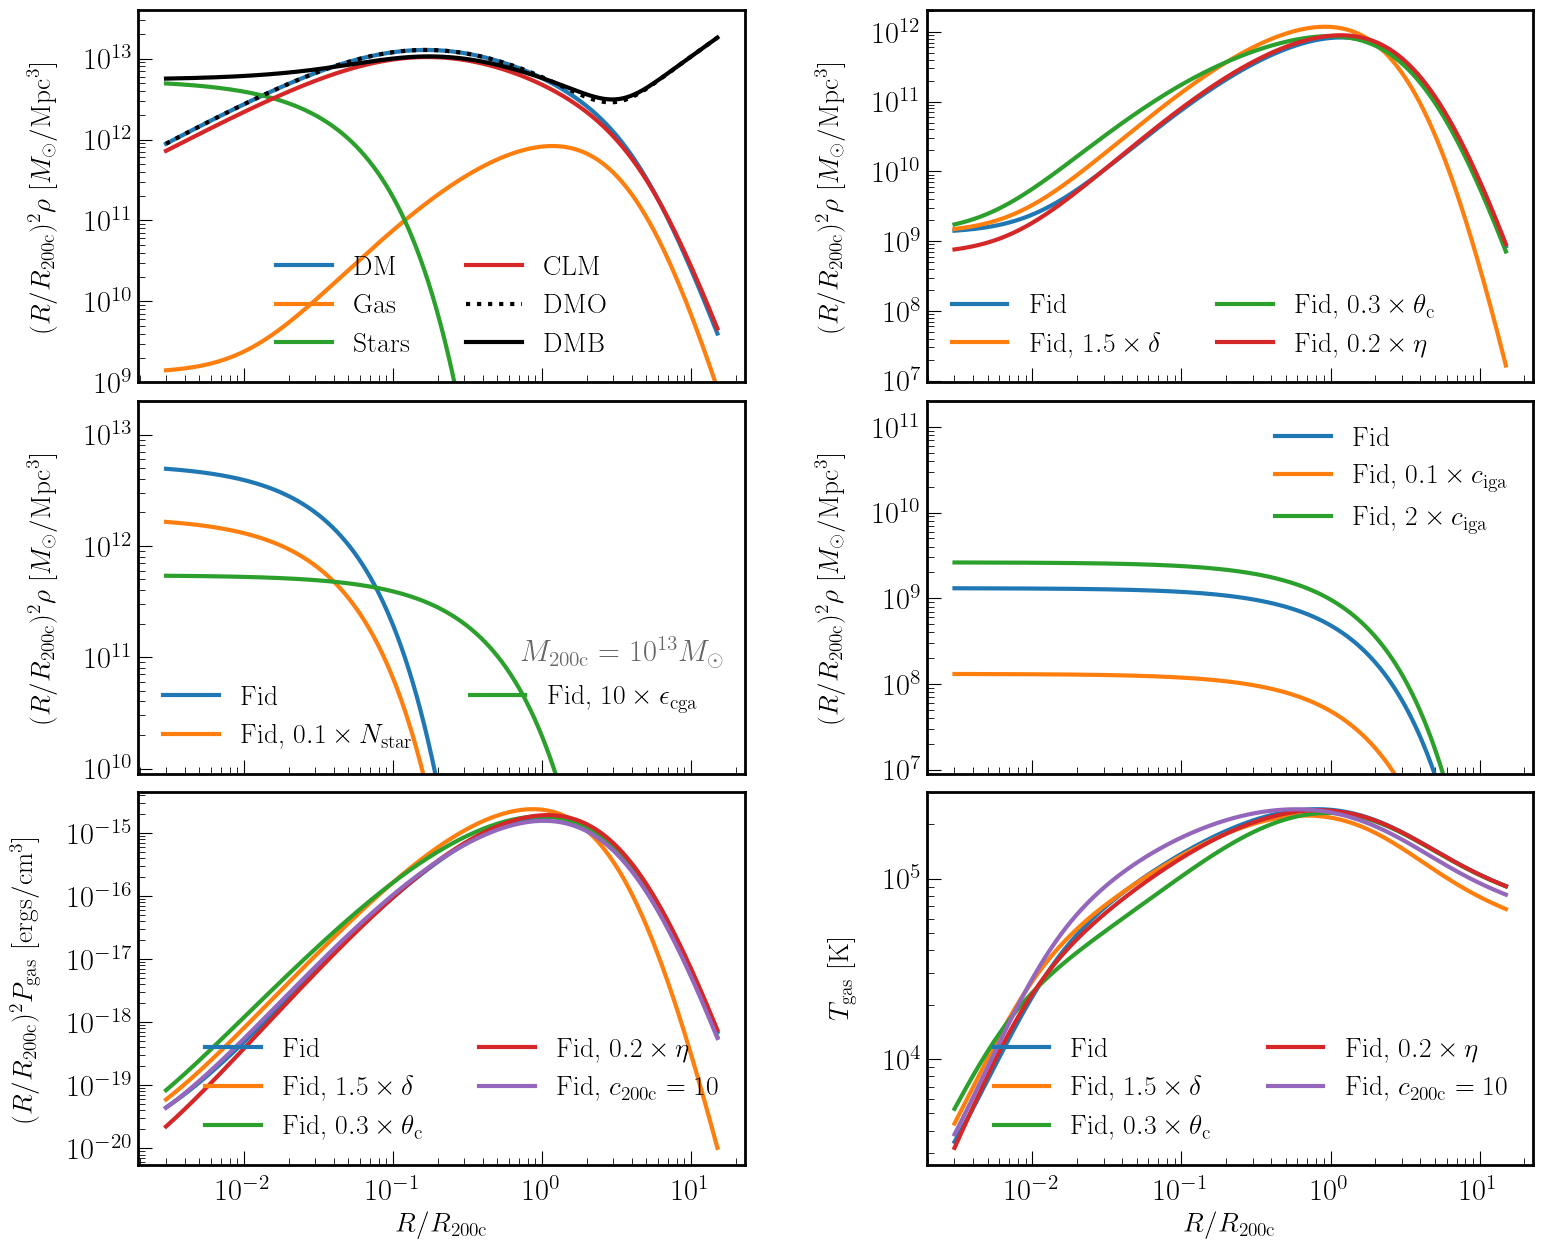

In [12]:
fig, ax = plt.subplots(3, 2, figsize = (18, 15), sharex = True, sharey = False)
plt.subplots_adjust(hspace = 0.05, wspace = 0.3)
[a.set_xscale('log') for a in ax.flat]
[a.set_yscale('log') for a in ax.flat]

#convenience function to give new dictionary with just one param changed
def bpar_new(p, bpar = bpar):
    return {k:v for k,v in bpar.items() if k != p}

def PressureIt(bpar, **kwargs):
    
    GAS = bfg.Profiles.Schneider25.Gas(**bpar, **kwargs)
    DMB = bfg.Profiles.Schneider25.DarkMatterBaryon(**bpar, **kwargs, twohalo = bfg.Profiles.misc.Zeros())
    
    PRS = bfg.Profiles.Pressure(GAS, DMB, **bpar, **kwargs)
    PRS = PRS * bfg.Profiles.NonThermalFrac(**bpar, **kwargs)
    
    return PRS

def TempIt(bpar, **kwargs):
    
    GAS = bfg.Profiles.Schneider25.Gas(**bpar, **kwargs)
    DMB = bfg.Profiles.Schneider25.DarkMatterBaryon(**bpar, **kwargs, twohalo = bfg.Profiles.misc.Zeros())
    
    PRS = bfg.Profiles.Pressure(GAS, DMB, **bpar, **kwargs)
    PRS = PRS * bfg.Profiles.NonThermalFrac(**bpar, **kwargs)
    GAS = bfg.Profiles.GasNumberDensity(GAS, **bpar, **kwargs)
    TMP = bfg.Profiles.Temperature(PRS, GAS)
    
    return TMP


#Init the profiles using dictionary of params
DM  = bfg.Profiles.Schneider25.DarkMatter(**bpar)
GAS = bfg.Profiles.Schneider25.Gas(**bpar)
STR = bfg.Profiles.Schneider25.Stars(**bpar)
CLM = bfg.Profiles.Schneider25.CollisionlessMatter(**bpar, r_max_int = 100)
DMO = bfg.Profiles.Schneider25.DarkMatterOnly(**bpar)
DMB = bfg.Profiles.Schneider25.DarkMatterBaryon(**bpar)

#Pick a mass, in Msun
M = 1e13
a = 1 #scale factor
R200c = ccl.halos.massdef.MassDef200c.get_radius(cosmo, M, a)
R = np.geomspace(0.003 * R200c, 15 * R200c, 1000)
x = R/R200c
mdef = ccl.halos.massdef.MassDef200c


#First plot fiducial dist
ax.flat[0].plot(x, x**2 * DM.real(cosmo, R, np.array(M), a), lw = 3,  label = 'DM')
ax.flat[0].plot(x, x**2 * GAS.real(cosmo, R, np.array(M), a), lw = 3, label = 'Gas')
ax.flat[0].plot(x, x**2 * STR.real(cosmo, R, np.array(M), a), lw = 3, label = 'Stars')
ax.flat[0].plot(x, x**2 * CLM.real(cosmo, R, np.array(M), a), lw = 3, label = 'CLM')
ax.flat[0].plot(x, x**2 * DMO.real(cosmo, R, np.array(M), a), lw = 3, ls = ':', label = 'DMO', color = 'k')
ax.flat[0].plot(x, x**2 * DMB.real(cosmo, R, np.array(M), a), lw = 3, ls = '-', label = 'DMB', color = 'k')
ax.flat[0].set_ylim(1e9, 4e13)


# #Now the gas variations
ax.flat[1].plot(x, x**2 * GAS.real(cosmo, R, np.array(M), a), lw = 3, label = 'Fid')
ax.flat[1].plot(x, x**2 * bfg.Profiles.Schneider25.Gas(**bpar_new('delta'), delta = 21/2).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $1.5\times\delta$')
ax.flat[1].plot(x, x**2 * bfg.Profiles.Schneider25.Gas(**bpar_new('theta_c'), theta_c = 0.1).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.3 \times\theta_{\rm c}$')
ax.flat[1].plot(x, x**2 * bfg.Profiles.Schneider25.Gas(**bpar_new('eta'), eta = 0.3).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.2\times \eta$')

# #Now the star variations
ax.flat[2].plot(x, x**2 * STR.real(cosmo, R, np.array(M), a), lw = 3, label = 'Fid')
ax.flat[2].plot(x, x**2 * bfg.Profiles.Schneider25.Stars(**bpar_new('Nstar'), Nstar = 0.01).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.1 \times N_{\rm star}$')
ax.flat[2].plot(x, x**2 * bfg.Profiles.Schneider25.Stars(**bpar_new('epsilon_cga'), epsilon_cga = 0.30).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $10\times \epsilon_{\rm cga}$')
ax.flat[2].set_ylim(9e9, 2e13)

# #Now the inner gas variations
ax.flat[3].plot(x, x**2 * bfg.Profiles.Schneider25.InnerGas(**bpar).real(cosmo, R, np.array(M), a), lw = 3, label = 'Fid')
ax.flat[3].plot(x, x**2 * bfg.Profiles.Schneider25.InnerGas(**bpar_new('c_iga'), c_iga = 0.01).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.1 \times c_{\rm iga}$')
ax.flat[3].plot(x, x**2 * bfg.Profiles.Schneider25.InnerGas(**bpar_new('c_iga'), c_iga = 0.2).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $2 \times c_{\rm iga}$')
ax.flat[3].set_ylim(9e6, 2e11)


# #Now the pressure profiles
ax.flat[4].plot(x, x**2 * PressureIt(bpar).real(cosmo, R, np.array(M), a), lw = 3, label = 'Fid')
ax.flat[4].plot(x, x**2 * PressureIt(bpar_new('delta'), delta = 21/2).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $1.5\times\delta$')
ax.flat[4].plot(x, x**2 * PressureIt(bpar_new('theta_c'), theta_c = 0.1).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.3 \times\theta_{\rm c}$')
ax.flat[4].plot(x, x**2 * PressureIt(bpar_new('eta'), eta = 0.3).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.2\times \eta$')
ax.flat[4].plot(x, x**2 * PressureIt(bpar_new('cdelta'), cdelta = 10).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $c_{\rm 200c} = 10$')

#Now the Temperature profiles
ax.flat[5].plot(x, TempIt(bpar).real(cosmo, R, np.array(M), a), lw = 3, label = 'Fid')
ax.flat[5].plot(x, TempIt(bpar_new('delta'), delta = 21/2).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $1.5\times\delta$')
ax.flat[5].plot(x, TempIt(bpar_new('theta_c'), theta_c = 0.1).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.3 \times\theta_{\rm c}$')
ax.flat[5].plot(x, TempIt(bpar_new('eta'), eta = 0.3).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.2\times \eta$')
ax.flat[5].plot(x, TempIt(bpar_new('cdelta'), cdelta = 10).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $c_{\rm 200c} = 10$')

ax[0, 0].set_ylabel(r'$(R/R_{\rm 200c})^2\rho$  $[M_\odot/{\rm Mpc}^3]$', size = 20, labelpad = 20)
ax[0, 1].set_ylabel(r'$(R/R_{\rm 200c})^2\rho$  $[M_\odot/{\rm Mpc}^3]$', size = 20, labelpad = 20)
ax[1, 0].set_ylabel(r'$(R/R_{\rm 200c})^2\rho$  $[M_\odot/{\rm Mpc}^3]$', size = 20, labelpad = 20)
ax[1, 1].set_ylabel(r'$(R/R_{\rm 200c})^2\rho$  $[M_\odot/{\rm Mpc}^3]$', size = 20, labelpad = 20)
ax[2, 0].set_ylabel(r'$(R/R_{\rm 200c})^2 P_{\rm gas}$  $[\rm ergs/cm^3]$', size = 20, labelpad = 20)
ax[2, 1].set_ylabel(r'$T_{\rm gas}$  $[\rm K]$', size = 20, labelpad = 20)

ax[2, 0].set_xlabel(r'$R/R_{\rm 200c}$', size = 20)
ax[2, 1].set_xlabel(r'$R/R_{\rm 200c}$', size = 20)

ax[2, 0].tick_params(axis = 'x', pad = 10)
ax[2, 1].tick_params(axis = 'x', pad = 10)
ax[2, 0].text(0.63, 0.3, r'$M_{\rm 200c} = 10^{%d}M_\odot$' % int(np.log10(M)), size = 22,
              color = 'k', alpha = 0.6, ha = 'left', transform = ax[1, 0].transAxes)

[ax.flat[i].legend(fontsize = 20, frameon = False, ncol = 2) for i in range(6)]
ax.flat[3].legend(fontsize = 20, frameon = False, ncol = 1)

plt.show()

In [13]:
DMO = bfg.Profiles.Schneider25.DarkMatterOnly(**bpar)
DMB = bfg.Profiles.Schneider25.DarkMatterBaryon(**bpar)

Displacement = bfg.Baryonification3D(DMO, DMB, cosmo, N_int = 50_000)
Displacement.setup_interpolator(N_samples_z = 2, z_min = 0, z_linear_sampling = True, 
                                R_min = 0.001, R_max = 150, N_samples_R = 10000,
                                M_min = 1e12, M_max = 2e16, N_samples_Mass = 5, Rdelta_sampling = False)

Building Table: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


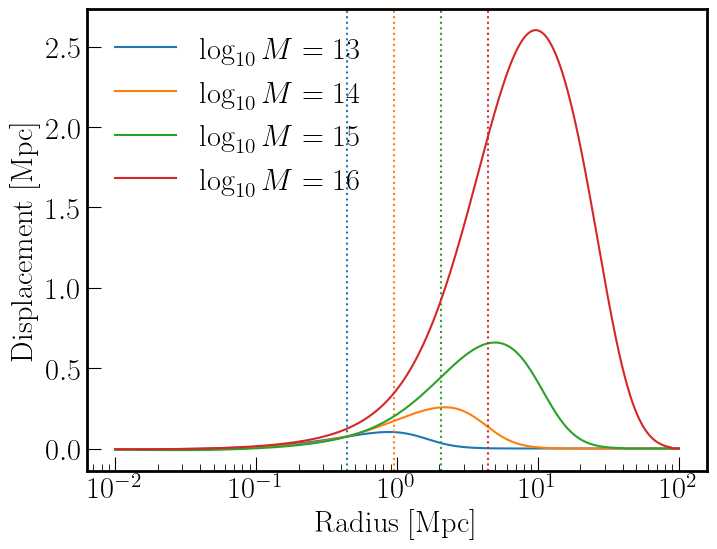

In [14]:
plt.figure(figsize = (8,6))
plt.xscale('log')
R = np.geomspace(1e-2, 100, 1000)
a = 1 #scale factor

for M in [1e13, 1e14, 1e15, 1e16]:
    R200c = ccl.halos.massdef.MassDef200c.get_radius(cosmo, M, a)
    c = plt.plot(R, Displacement.displacement(R, M, 1), label = r'$\log_{10}M = %d$' % np.log10(M))
    plt.axvline(R200c, color = c[0].get_color(), ls = ':')
    
plt.legend()
plt.xlabel('Radius [Mpc]')
plt.ylabel('Displacement [Mpc]')
plt.show()